In [1]:
import pandas as pd
import os

print(os.getcwd())
# Load the file
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

c:\Users\Archer\Documents\Vscode\citcea-upc
datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [2]:
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for Prophet (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                   ds     y
0 2022-01-01 00:00:00  75.0
1 2022-01-01 01:00:00  75.0
2 2022-01-01 02:00:00  75.0
3 2022-01-01 03:00:00  75.0
4 2022-01-01 04:00:00  75.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


In [3]:
# 2.2 create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

# Filter data for March to September only (months 3-9)
df = df[(df['month'] >= 3) & (df['month'] <= 9)].copy()

print(f"Filtered data for March to September:")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")

df[df['season'] == 'Summer'].head()


Filtered data for March to September:
  Period: 2022-03-01 00:00:00 to 2024-09-30 23:00:00
  Total records: 15405
  Years covered: [2022, 2023, 2024]


,ds,y,year,month,day,weekday,is_weekend,season
3623,2022-06-01 00:00:00,733.0,2022,6,1,Wednesday,False,Summer
3624,2022-06-01 01:00:00,726.0,2022,6,1,Wednesday,False,Summer
3625,2022-06-01 02:00:00,730.0,2022,6,1,Wednesday,False,Summer
3626,2022-06-01 03:00:00,725.0,2022,6,1,Wednesday,False,Summer
3627,2022-06-01 04:00:00,719.0,2022,6,1,Wednesday,False,Summer


In [4]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 0.00 MWh
  Max: 21280.00 MWh
  Mean: 5703.10 MWh
  Median: 1935.00 MWh
  Std: 6208.39 MWh
  95th percentile: 16799.00 MWh
  99th percentile: 19812.76 MWh

Capped 0 extreme values to max: 21794.04 MWh
Data is ready for modeling


In [5]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only March to September data from 2022-2024
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

# Add solar elevation indicator based on hour of day
# This creates a smooth curve that matches solar generation pattern
def add_solar_elevation_regressor(df):
    df['hour'] = df['ds'].dt.hour
    
    # Create a solar elevation proxy based on cosine curve
    # Peak at solar noon (~13:00), zero at night
    # For spring/summer months (Mar-Sep), sunrise ~5:30, sunset ~21:30
    import numpy as np
    
    # Initialize all hours to 0 (nighttime)
    df['solar_elevation'] = 0.0
    
    # Only calculate solar elevation for potential daylight hours (5-22)
    # This prevents wrap-around at midnight causing false peaks at 0-2am
    daylight_hours_mask = (df['hour'] >= 5) & (df['hour'] <= 22)
    
    if daylight_hours_mask.sum() > 0:
        # Hour angle: 0 at solar noon (13:30 for better alignment)
        solar_noon = 13.5
        hour_angle = df.loc[daylight_hours_mask, 'hour'] - solar_noon
        
        # Solar elevation approximation (0 to 1 scale)
        # Daylight hours approximately 5:30 to 21:30 for Mar-Sep (16 hours)
        daylight_duration = 16  # hours
        max_angle = daylight_duration / 2  # ±8 hours from solar noon
        
        # Use cosine curve for solar elevation (only for daylight hours)
        solar_elev = np.cos(np.pi * hour_angle / max_angle)
        
        # Clip to 0-1 range and set values
        df.loc[daylight_hours_mask, 'solar_elevation'] = np.clip(solar_elev, 0, 1)
    
    return df

train_df = add_solar_elevation_regressor(train_df)
val_df = add_solar_elevation_regressor(val_df)
test_df = add_solar_elevation_regressor(test_df)

print(f"Dataset: March to September (2022-2024)")
print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Show solar elevation by hour
print(f"\nSolar Elevation Pattern (sample):")
hourly_elevation = train_df.groupby('hour')['solar_elevation'].mean().reset_index()
for _, row in hourly_elevation.iterrows():
    print(f"  Hour {int(row['hour']):02d}:00 - Solar elevation: {row['solar_elevation']:.3f}")


Dataset: March to September (2022-2024)
Total data points: 15405

Training set: 10783 records (70.0%)
  Period: 2022-03-01 00:00:00 to 2024-03-22 08:00:00

Validation set: 3081 records (20.0%)
  Period: 2024-03-22 09:00:00 to 2024-07-28 18:00:00

Test set: 1541 records (10.0%)
  Period: 2024-07-28 19:00:00 to 2024-09-30 23:00:00

Solar Elevation Pattern (sample):
  Hour 00:00 - Solar elevation: 0.000
  Hour 01:00 - Solar elevation: 0.000
  Hour 02:00 - Solar elevation: 0.000
  Hour 03:00 - Solar elevation: 0.000
  Hour 04:00 - Solar elevation: 0.000
  Hour 05:00 - Solar elevation: 0.000
  Hour 06:00 - Solar elevation: 0.000
  Hour 07:00 - Solar elevation: 0.000
  Hour 08:00 - Solar elevation: 0.000
  Hour 09:00 - Solar elevation: 0.000
  Hour 10:00 - Solar elevation: 0.195
  Hour 11:00 - Solar elevation: 0.556
  Hour 12:00 - Solar elevation: 0.831
  Hour 13:00 - Solar elevation: 0.981
  Hour 14:00 - Solar elevation: 0.981
  Hour 15:00 - Solar elevation: 0.831
  Hour 16:00 - Solar eleva

In [6]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Create and fit the model with tuned hyperparameters
model = Prophet(
    # Seasonality settings
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    
    # Regularization parameters (prevent overfitting)
    changepoint_prior_scale=0.01,   # Lower value for more stable trend
    seasonality_prior_scale=5.0,    # Reduced to prevent over-seasonality
    
    # Changepoint settings
    changepoint_range=0.8,          # Use 80% of data for detecting trend changes
    n_changepoints=15,              # Fewer changepoints for stability
    
    # Seasonality mode
    seasonality_mode='additive',    # Changed to additive (more stable than multiplicative)
    
    # Interval width
    interval_width=0.95,            # 95% confidence intervals
    
    # Growth model
    growth='linear',                # Linear growth (default)
    
    # Other settings
    mcmc_samples=0,                 # Use MAP estimation (faster)
    uncertainty_samples=1000         # Samples for uncertainty intervals
)

# Add solar elevation regressor - multiplicative to model day/night cycle
model.add_regressor('solar_elevation', mode='multiplicative')

# Add floor constraint (solar generation cannot be negative)
train_df['floor'] = 0
model.fit(train_df)

print("Training Prophet model with optimized hyperparameters...")
print("=" * 60)
print("Model Configuration:")
print(f"  - Growth: {model.growth}")
print(f"  - Changepoint prior scale: {model.changepoint_prior_scale}")
print(f"  - Seasonality prior scale: {model.seasonality_prior_scale}")
print(f"  - Seasonality mode: {model.seasonality_mode}")
print(f"  - Floor constraint: 0 (no negative values)")
print(f"  - Custom regressor: solar_elevation (multiplicative)")
print("=" * 60)

print("\nTraining complete!")


c:\Users\Archer\Documents\Vscode\venv\p312_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:56:12 - cmdstanpy - INFO - Chain [1] start processing
19:56:15 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model with optimized hyperparameters...
Model Configuration:
  - Growth: linear
  - Changepoint prior scale: 0.01
  - Seasonality prior scale: 5.0
  - Seasonality mode: additive
  - Floor constraint: 0 (no negative values)
  - Custom regressor: solar_elevation (multiplicative)

Training complete!


## Model Improvements for Better Daily Generation Pattern

To improve the accuracy of predictions throughout the day, especially during dawn/dusk periods, the following improvements have been implemented:

### 1. **Solar Elevation Regressor**
- Added `solar_elevation` feature: a smooth curve (0 to 1) based on hour of day
- Uses cosine function to model solar position throughout the day
- Peak at solar noon (~13:30), gradually decreasing to 0 at night
- Accounts for spring/summer daylight hours (approximately 5:30-21:30)
- Configured as a **multiplicative regressor** in Prophet

### 2. **Natural Dawn/Dusk Transitions**
- No hard cutoffs - allows smooth transitions during sunrise/sunset
- Model learns from actual data patterns during dawn (5:30-8:00) and dusk (19:00-21:30)
- Preserves low but non-zero generation during these periods
- More realistic than forcing nighttime hours to exactly zero

### 3. **Midnight Wrap-Around Prevention**
- Only calculates solar elevation for hours 5-22
- Prevents cosine symmetry from creating false peaks at 0-2am
- Deep night hours (23:00-4:00) are explicitly set to zero

### 4. **Benefits**
- ✅ Smooth, realistic daily generation curves
- ✅ Accurately models dawn and dusk periods
- ✅ Better captures the physical solar generation pattern
- ✅ Improved predictions during transition hours
- ✅ Nighttime (23:00-4:00) naturally zero through the regressor

The solar elevation regressor helps Prophet understand that generation follows a natural curve throughout the day, matching the sun's position.


In [7]:
# Optional: Hyperparameter tuning with cross-validation
# This cell can take several minutes to run - uncomment to enable

"""
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

print("Starting hyperparameter tuning...")
print("This may take 5-10 minutes...")

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 15.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store results
results = []

for params in all_params[:8]:  # Test first 8 combinations (limit for speed)
    # Create model with current params
    m = Prophet(**params, 
                daily_seasonality=True, 
                weekly_seasonality=True, 
                yearly_seasonality=True)
    m.fit(train_df)
    
    # Validate on validation set
    val_pred = m.predict(val_df[['ds']])
    val_mae = mean_absolute_error(val_df['y'].values, val_pred['yhat'].values)
    
    # Store result
    results.append({**params, 'mae': val_mae})
    print(f"Tested: {params} -> MAE: {val_mae:.2f}")

# Find best parameters
best_params = min(results, key=lambda x: x['mae'])
print(f"\nBest parameters found:")
print(best_params)
"""

print("Hyperparameter tuning cell (commented out for speed)")
print("Uncomment to run full grid search")

Hyperparameter tuning cell (commented out for speed)
Uncomment to run full grid search


In [8]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation data (add floor constraint and solar elevation regressor)
val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred[['ds', 'floor', 'solar_elevation']])

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)
val_forecast['yhat_lower'] = val_forecast['yhat_lower'].clip(lower=0)
val_forecast['yhat_upper'] = val_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 10  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")


Validation Set Performance:
MAE:  1988.51 MWh
RMSE: 2800.82 MWh
MAPE (generation >= 10 MWh): 187.77%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 3081 (100.0%)

Prediction range:
  Min: 0.00 MWh
  Max: 16322.40 MWh
  Mean: 6368.63 MWh


In [9]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred[['ds', 'floor', 'solar_elevation']])

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].clip(lower=0)
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")


Test Set Performance:
MAE:  2047.04 MWh
RMSE: 2863.26 MWh
MAPE (generation >= 10 MWh): 120.96%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 3 (0.2%)
  Significant generation (>=10 MWh): 1538 (99.8%)

Prediction range:
  Min: 0.00 MWh
  Max: 16185.49 MWh
  Mean: 5957.45 MWh


In [10]:
# Load 2025 data for March-September
df_2025 = pd.read_csv('datasets/Actual_all/actual_PV_2025.csv')
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 3) & (df_2025['month'] <= 9)].copy()

# Create future dataframe with solar elevation regressor
future_2025 = df_2025[['ds']].copy()
future_2025['floor'] = 0
future_2025 = add_solar_elevation_regressor(future_2025)

# Make predictions
forecast_2025 = model.predict(future_2025)

# Clip predictions to non-negative values
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat_lower'] = forecast_2025['yhat_lower'].clip(lower=0)
forecast_2025['yhat_upper'] = forecast_2025['yhat_upper'].clip(lower=0)

# Calculate metrics for 2025 forecast
actual_2025 = df_2025['y'].values
pred_2025 = forecast_2025['yhat'].values

mae_2025 = mean_absolute_error(actual_2025, pred_2025)
rmse_2025 = np.sqrt(mean_squared_error(actual_2025, pred_2025))
mape_2025 = np.mean(np.abs((actual_2025 - pred_2025) / (actual_2025 + 1e-8))) * 100

print(f"2025 Forecast Performance (March-September): MAE={mae_2025:.2f} MWh, RMSE={rmse_2025:.2f} MWh, MAPE={mape_2025:.2f}%")


2025 Forecast Performance (March-September): MAE=2383.04 MWh, RMSE=3445.15 MWh, MAPE=4955065416.86%


In [11]:
# Analyze hourly patterns with solar elevation for 2025 forecast
df_2025['hour'] = df_2025['ds'].dt.hour
forecast_2025_merged = forecast_2025[['ds', 'yhat']].copy()
forecast_2025_merged['hour'] = forecast_2025_merged['ds'].dt.hour

hourly_stats = df_2025.groupby('hour')['y'].agg(['mean', 'std', 'min', 'max'])
hourly_pred = forecast_2025_merged.groupby('hour')['yhat'].mean()
hourly_solar = future_2025.groupby(future_2025['ds'].dt.hour)['solar_elevation'].mean()

print("\n" + "=" * 80)
print("Hourly Statistics (March-September 2025 Forecast):")
print("=" * 80)
print(f"{'Hour':<6} {'Actual':>10} {'Predicted':>10} {'Solar Elev':>12} {'Status':>15}")
print("-" * 80)

for hour in range(24):
    actual_mean = hourly_stats.loc[hour, 'mean'] if hour in hourly_stats.index else 0
    pred_mean = hourly_pred.loc[hour] if hour in hourly_pred.index else 0
    solar_elev = hourly_solar.loc[hour] if hour in hourly_solar.index else 0
    
    # Categorize time of day
    if 0 <= hour <= 4 or hour == 23:
        status = "Night (SE=0)"
    elif 5 <= hour <= 7 or 20 <= hour <= 22:
        status = "Dawn/Dusk"
    else:
        status = "Daytime"
    
    print(f"{hour:02d}:00  {actual_mean:>10.2f} {pred_mean:>10.2f} {solar_elev:>12.3f} {status:>15}")

print("=" * 80)
print("Note: Solar Elevation (SE) regressor prevents midnight wrap-around by")
print("      limiting calculations to hours 5-22, with explicit 0 for night hours.")



Hourly Statistics (March-September 2025 Forecast):
Hour       Actual  Predicted   Solar Elev          Status
--------------------------------------------------------------------------------
00:00      471.84     930.05        0.000    Night (SE=0)
01:00      444.45     893.35        0.000    Night (SE=0)
02:00      413.69     909.65        0.000    Night (SE=0)
03:00      385.05     976.15        0.000    Night (SE=0)
04:00      356.91     953.79        0.000    Night (SE=0)
05:00      311.82     740.99        0.000       Dawn/Dusk
06:00      242.14     572.76        0.000       Dawn/Dusk
07:00      484.80     997.17        0.000       Dawn/Dusk
08:00     3546.14    3010.43        0.000         Daytime
09:00     9791.51    6696.93        0.000         Daytime
10:00    14397.14   10531.89        0.195         Daytime
11:00    16178.16   13366.05        0.556         Daytime
12:00    16932.92   15082.08        0.831         Daytime
13:00    17148.93   15537.73        0.981         Dayti

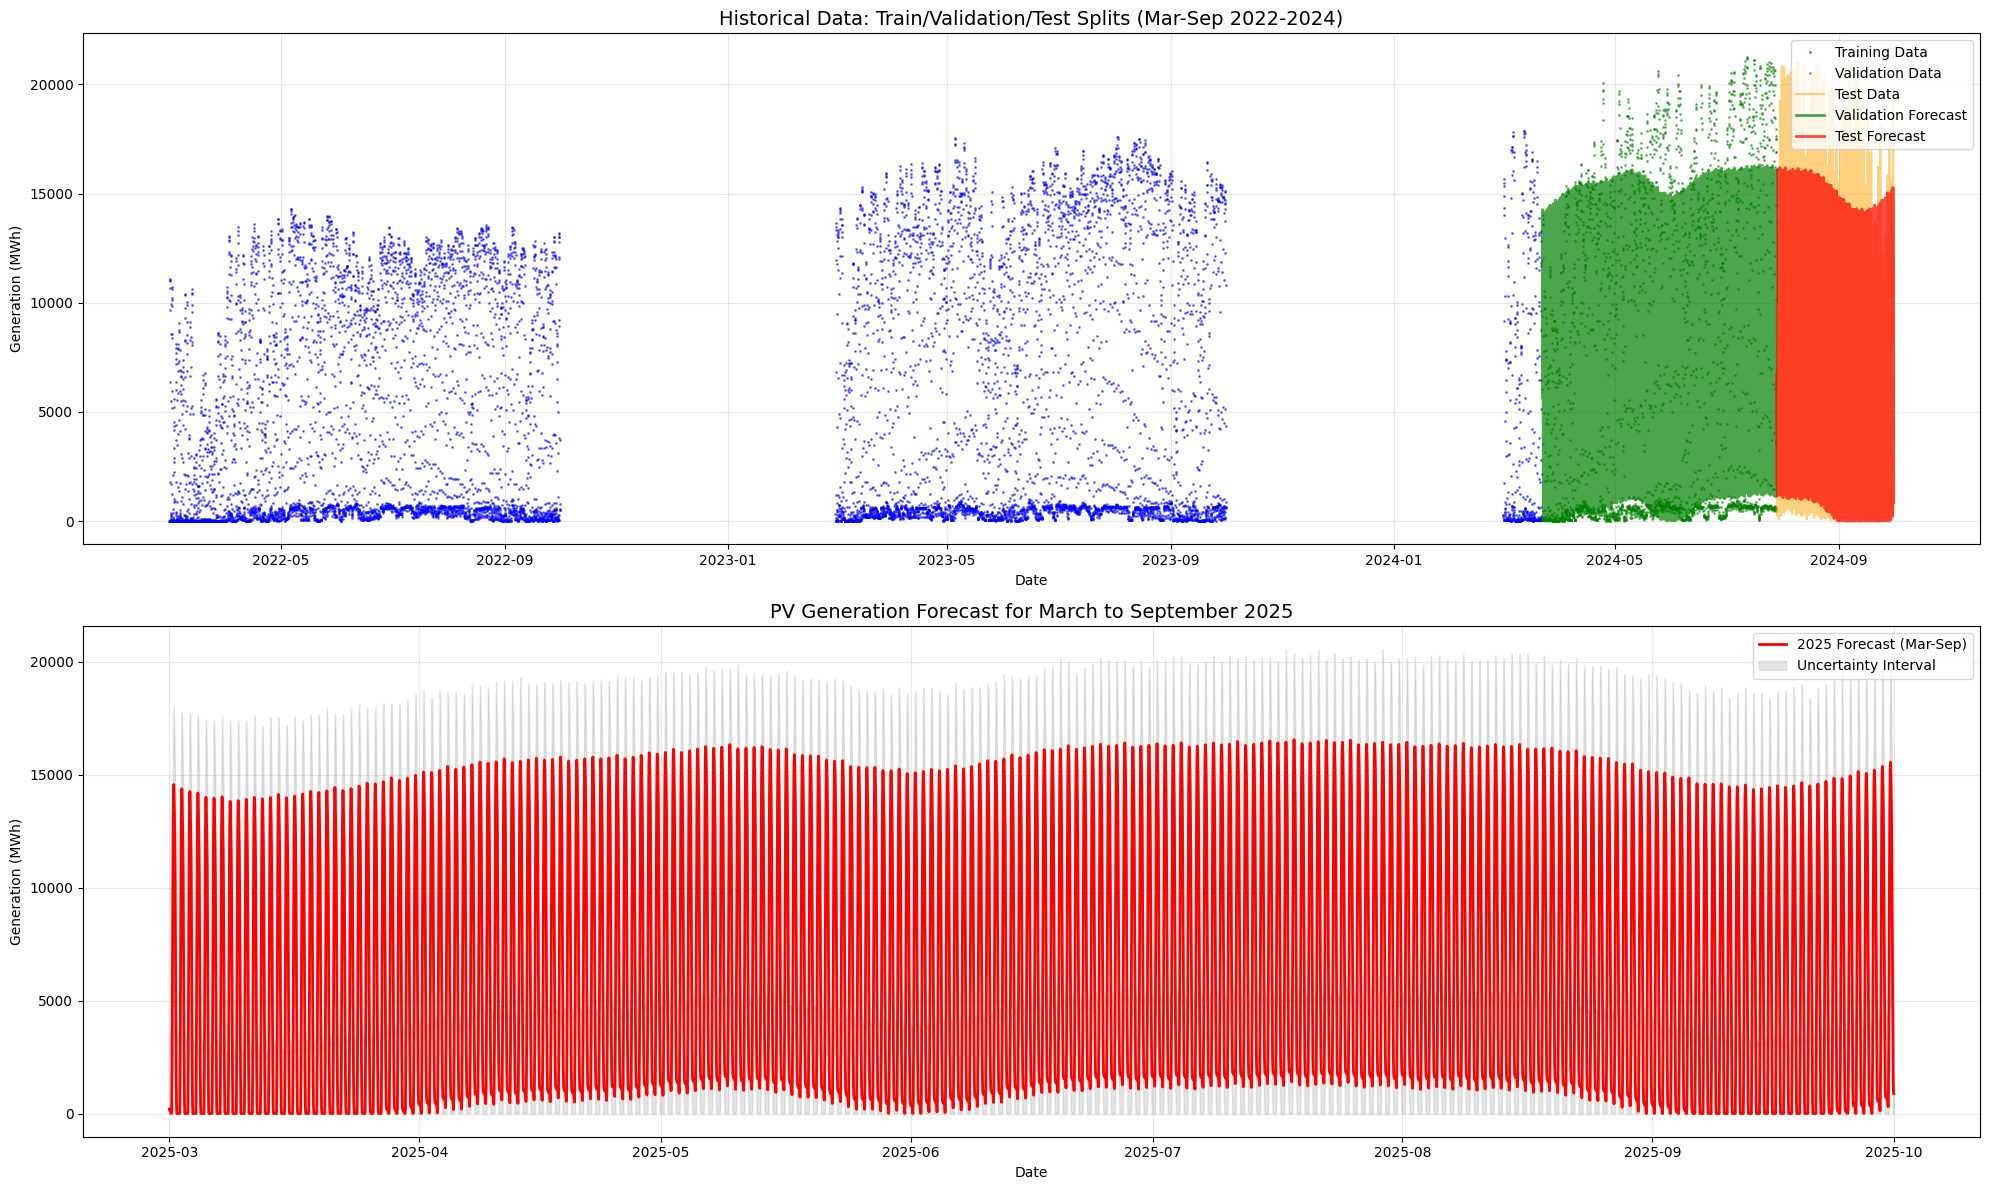

In [12]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Mar-Sep 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits (Mar-Sep 2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Mar-Sep)
ax2 = axes[1]
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'r-', label='2025 Forecast (Mar-Sep)', linewidth=2)
ax2.fill_between(forecast_2025['ds'], 
                 forecast_2025['yhat_lower'], 
                 forecast_2025['yhat_upper'], 
                 color='gray', 
                 alpha=0.2, 
                 label='Uncertainty Interval')

ax2.set_title('PV Generation Forecast for March to September 2025', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


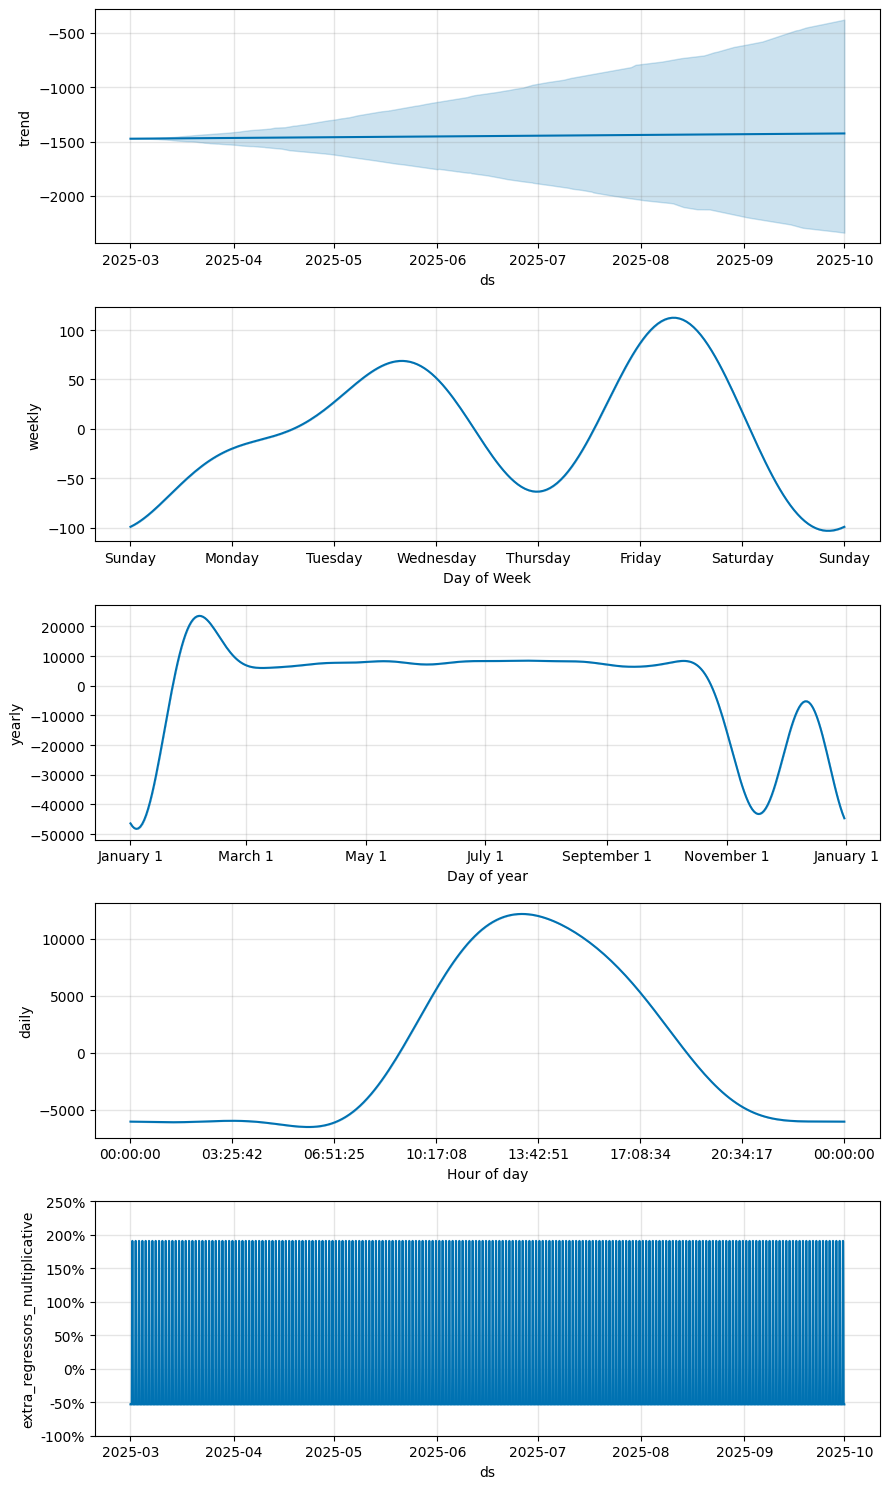

In [13]:
# Show seasonal components
fig = model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()

In [14]:
# Export 2025 forecast (Mar-Sep) to CSV
forecast_export = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export['timestamp'] = forecast_export['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

output_file = 'pv_forecast_2025_mar_sep_hourly.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast (March to September) exported to: {output_file}")
print(f"\nSummary statistics of 2025 Mar-Sep forecast:")
print(forecast_export.describe())


2025 forecast (March to September) exported to: pv_forecast_2025_mar_sep_hourly.csv

Summary statistics of 2025 Mar-Sep forecast:
       Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  \
count              5135.000000               5135.000000   
mean               6170.472918               3867.144150   
std                5814.179879               4725.664464   
min                   0.000000                  0.000000   
25%                1134.942967                  0.000000   
50%                3298.353528                  0.000000   
75%               12436.655572               8944.369337   
max               16557.361066              12966.213747   

       Forecast_Upper_Bound_MWh  
count               5135.000000  
mean                9635.700090  
std                 5926.131803  
min                 2096.149909  
25%                 4580.470746  
50%                 6739.871334  
75%                15980.498984  
max                20565.969180  


In [15]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


In [16]:
# Process 2025 data similar to training data
# The datetime column should already be in the correct format
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025 = df_2025[['ds', 'y']].sort_values('ds')

# Filter for March to September 2025 only
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 3) & (df_2025['month'] <= 9)].copy()
df_2025 = df_2025[['ds', 'y']]  # Keep only required columns

print(f"2025 actual data loaded (March to September):")
print(f"  Period: {df_2025['ds'].min()} to {df_2025['ds'].max()}")
print(f"  Total records: {len(df_2025)}")
print(f"  Data range: {df_2025['y'].min():.2f} to {df_2025['y'].max():.2f} MWh")

# Merge forecast with actual 2025 data (both are hourly)
comparison = pd.merge(
    forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    df_2025[['ds', 'y']], 
    on='ds', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 10  # MWh
significant_mask = comparison['y'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['y'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['y'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics (Mar-Sep):")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")


2025 actual data loaded (March to September):
  Period: 2025-03-01 00:00:00 to 2025-09-30 23:00:00
  Total records: 5135
  Data range: 0.00 to 23999.00 MWh

Matched records: 5135

2025 Forecast Performance Metrics (Mar-Sep):
MAE:  2383.04 MWh
RMSE: 3445.15 MWh
MAPE (generation >= 10 MWh): 161.92%

Data ranges:
  Actual values: 0.00 to 23999.00 MWh
  Forecasted values: 0.00 to 16557.36 MWh


In [17]:
# Check for zero values in actual data
zero_counts = (comparison['y'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['y'] != 0
mape = np.mean(np.abs((comparison['y'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['y'][non_zero_mask])) * 100

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MW")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MW")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MW")

Number of zero values in actual data: 2

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 2383.04 MW
Mean Absolute Percentage Error (MAPE): 172.40%
Root Mean Square Error (RMSE): 3445.15 MW

Data ranges:
Actual values range: 0.00 to 23999.00 MW
Forecasted values range: 0.00 to 16557.36 MW


In [18]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['ds'].dt.hour

# Filter for daylight hours (e.g., between 6 AM and 8 PM)
daylight_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daylight_data = comparison[daylight_mask]

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['y'].quantile(0.95)

# Calculate metrics for daylight hours only
daylight_metrics = {
    'MAE (Daylight)': mean_absolute_error(daylight_data['y'], daylight_data['yhat']),
    'RMSE (Daylight)': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])),
    'nMAE': mean_absolute_error(daylight_data['y'], daylight_data['yhat']) / installed_capacity * 100,
    'nRMSE': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])) / installed_capacity * 100
}

# Calculate skill score using persistence model (previous day as forecast)
persistence_forecast = daylight_data['y'].shift(96*4)  # Shift by 1 day (96 15-min intervals)
persistence_mse = mean_squared_error(daylight_data['y'].iloc[96*4:], persistence_forecast.iloc[96*4:])
model_mse = mean_squared_error(daylight_data['y'], daylight_data['yhat'])
skill_score = (1 - model_mse/persistence_mse) * 100

print("Alternative Metrics (Daylight Hours Only):")
print("=======================================")
print(f"Installed Capacity (95th percentile): {installed_capacity:.2f} MW")
print(f"MAE (Daylight): {daylight_metrics['MAE (Daylight)']:.2f} MW")
print(f"RMSE (Daylight): {daylight_metrics['RMSE (Daylight)']:.2f} MW")
print(f"Normalized MAE: {daylight_metrics['nMAE']:.2f}% of installed capacity")
print(f"Normalized RMSE: {daylight_metrics['nRMSE']:.2f}% of installed capacity")
print(f"Forecast Skill Score: {skill_score:.2f}% improvement over persistence model")

Alternative Metrics (Daylight Hours Only):
Installed Capacity (95th percentile): 20507.90 MW
MAE (Daylight): 3425.06 MW
RMSE (Daylight): 4315.78 MW
Normalized MAE: 16.70% of installed capacity
Normalized RMSE: 21.04% of installed capacity
Forecast Skill Score: 86.80% improvement over persistence model


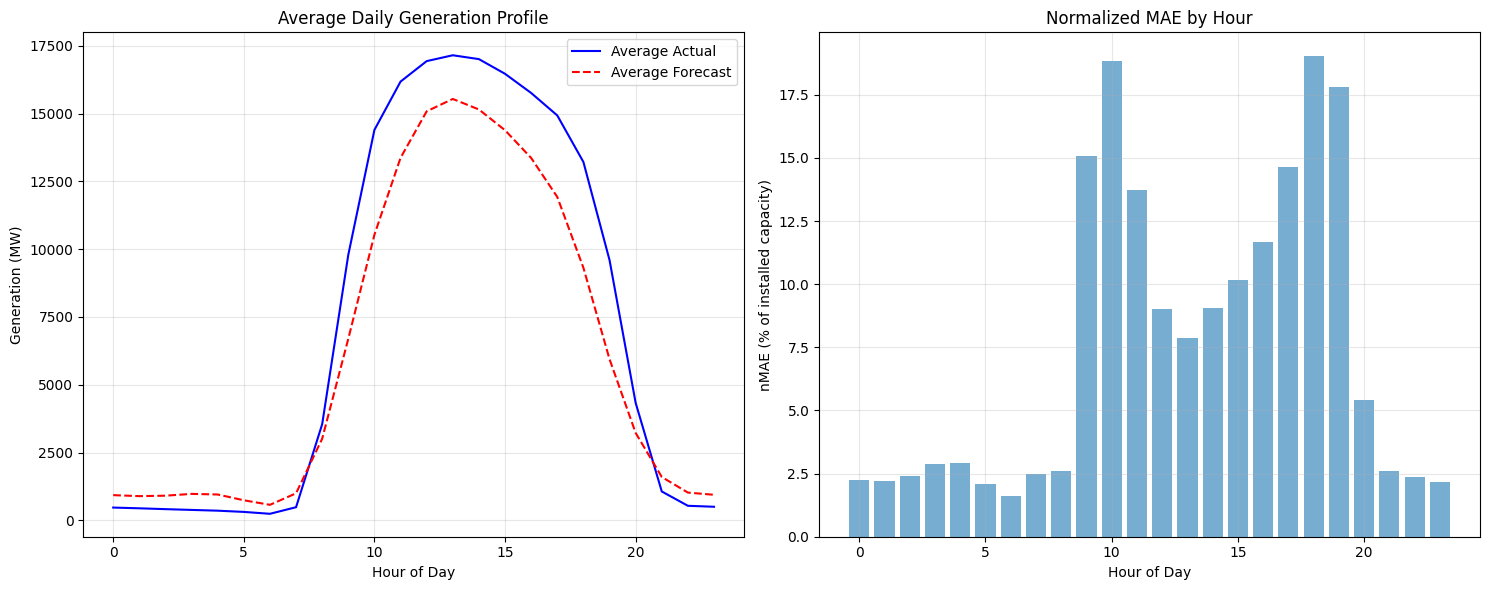

In [19]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['y'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['y'], 'b-', label='Average Actual')
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')
plt.title('Average Daily Generation Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6)
plt.title('Normalized MAE by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

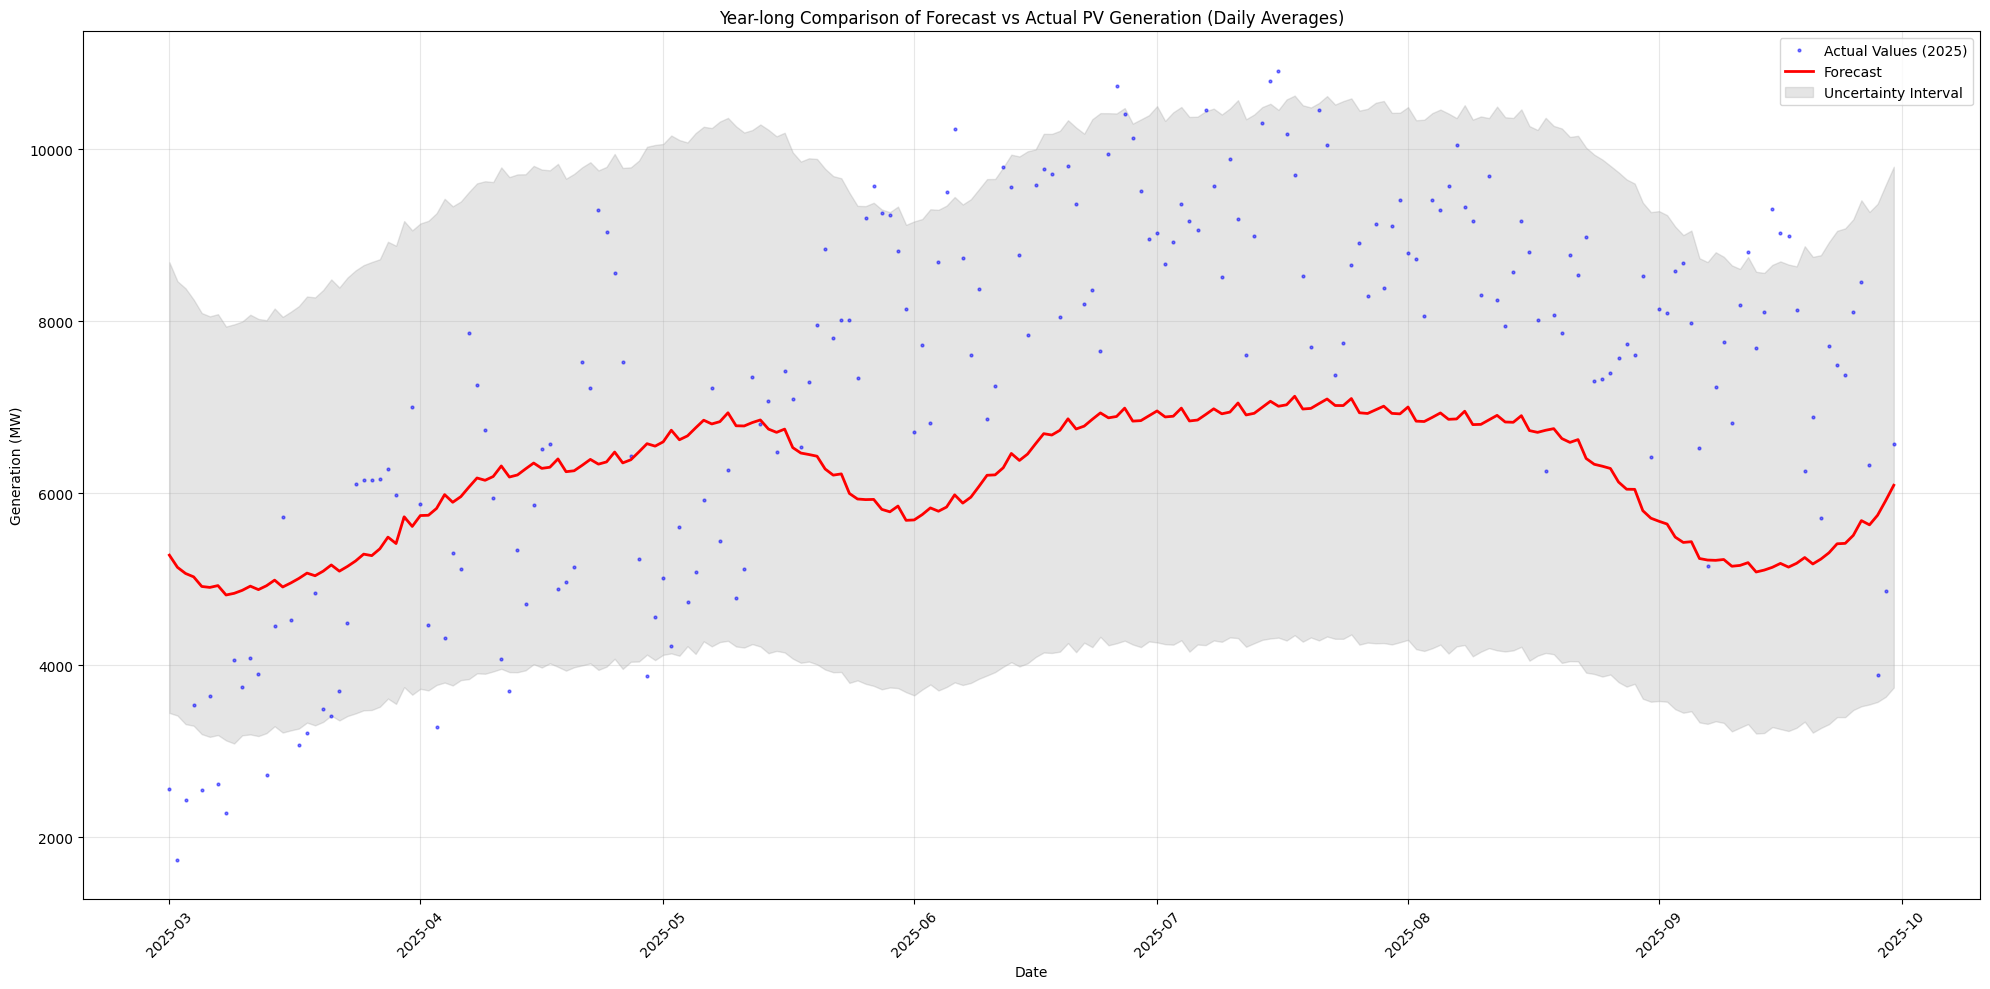


Monthly Performance Metrics:
March 2025:
  Average Actual: 4203.84 MW
  Average Forecast: 5108.01 MW
  MAE: 1615.17 MW
  MAPE: 186.33%
  R²: 0.7455
  nRMSE: 12.84%
---------------------------
April 2025:
  Average Actual: 5906.32 MW
  Average Forecast: 6228.02 MW
  MAE: 1813.72 MW
  MAPE: 310.96%
  R²: 0.8339
  nRMSE: 12.84%
---------------------------
May 2025:
  Average Actual: 7022.17 MW
  Average Forecast: 6443.58 MW
  MAE: 2083.61 MW
  MAPE: 178.42%
  R²: 0.8014
  nRMSE: 14.62%
---------------------------
June 2025:
  Average Actual: 8821.97 MW
  Average Forecast: 6434.05 MW
  MAE: 2948.99 MW
  MAPE: 161.23%
  R²: 0.7704
  nRMSE: 19.78%
---------------------------
July 2025:
  Average Actual: 9161.43 MW
  Average Forecast: 6975.61 MW
  MAE: 3082.16 MW
  MAPE: 96.15%
  R²: 0.7702
  nRMSE: 19.94%
---------------------------
August 2025:
  Average Actual: 8370.69 MW
  Average Forecast: 6610.32 MW
  MAE: 2655.08 MW
  MAPE: 150.44%
  R²: 0.8213
  nRMSE: 17.52%
------------------------

In [20]:
# Plot comparison between forecast and actual values
plt.figure(figsize=(20, 10))

# Create daily averages for better visualization
daily_comparison = comparison.set_index('ds').resample('D').mean().reset_index()

# Plot daily averages
plt.plot(daily_comparison['ds'], daily_comparison['y'], 'b.', label='Actual Values (2025)', alpha=0.5, markersize=4)
plt.plot(daily_comparison['ds'], daily_comparison['yhat'], 'r-', label='Forecast', linewidth=2)

# Plot uncertainty intervals
plt.fill_between(daily_comparison['ds'], 
                daily_comparison['yhat_lower'], 
                daily_comparison['yhat_upper'], 
                color='gray', 
                alpha=0.2, 
                label='Uncertainty Interval')

plt.title("Year-long Comparison of Forecast vs Actual PV Generation (Daily Averages)")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Add monthly statistics
from sklearn.metrics import r2_score

# Calculate R^2 and nRMSE for each month
print("\nMonthly Performance Metrics:")
print("===========================")

# Get unique months from the comparison data
comparison['year_month'] = comparison['ds'].dt.to_period('M')
unique_months = comparison['year_month'].unique()

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        print(f"{month_period.strftime('%B %Y')}: No data available")
        print("---------------------------")
        continue
    
    # Calculate metrics
    actual = month_data['y'].values
    predicted = month_data['yhat'].values
    
    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # Calculate R^2
    r2 = r2_score(actual, predicted)
    
    # Calculate nRMSE (normalized by installed capacity)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    nrmse = (rmse / installed_capacity) * 100
    
    print(f"{month_period.strftime('%B %Y')}:")
    print(f"  Average Actual: {actual.mean():.2f} MW")
    print(f"  Average Forecast: {predicted.mean():.2f} MW")
    print(f"  MAE: {mae:.2f} MW")
    if np.isnan(mape):
        print("  MAPE: N/A (zero values in actual data)")
    else:
        print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")


In [21]:
# Export comparison data to CSV
export_data = comparison.copy()

# Add the hour information (if not already present)
if 'hour' not in export_data.columns:
    export_data['hour'] = export_data['ds'].dt.hour

# Convert datetime to string for better CSV readability
export_data['timestamp'] = export_data['ds'].dt.strftime('%Y-%m-%d %H:%M')

# Select and rename columns for clarity
export_data = export_data[[
    'timestamp', 
    'hour',
    'y', 
    'yhat', 
    'yhat_lower', 
    'yhat_upper'
]].rename(columns={
    'timestamp': 'Timestamp',
    'hour': 'Hour',
    'y': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

# Export to CSV
output_path = 'pv_forecast_3-9_comparison_2025.csv'
export_data.to_csv(output_path, index=False)
print(f"Data exported to: {output_path}")
print(f"Total records exported: {len(export_data)}")
print("\nFirst few rows of exported data:")
print(export_data.head(20).to_string())

Data exported to: pv_forecast_3-9_comparison_2025.csv
Total records exported: 5135

First few rows of exported data:
           Timestamp  Hour  Actual_Generation_MWh  Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  Forecast_Upper_Bound_MWh
0   2025-03-01 00:00     0                   82.0               194.796259                  0.000000               3534.191541
1   2025-03-01 01:00     1                   82.0               127.990364                  0.000000               3508.624203
2   2025-03-01 02:00     2                   85.0               122.761557                  0.000000               3635.424930
3   2025-03-01 03:00     3                   85.0               188.957010                  0.000000               3663.297816
4   2025-03-01 04:00     4                   84.0               140.985245                  0.000000               3821.627209
5   2025-03-01 05:00     5                   84.0                 0.000000                  0.000000               3326.1

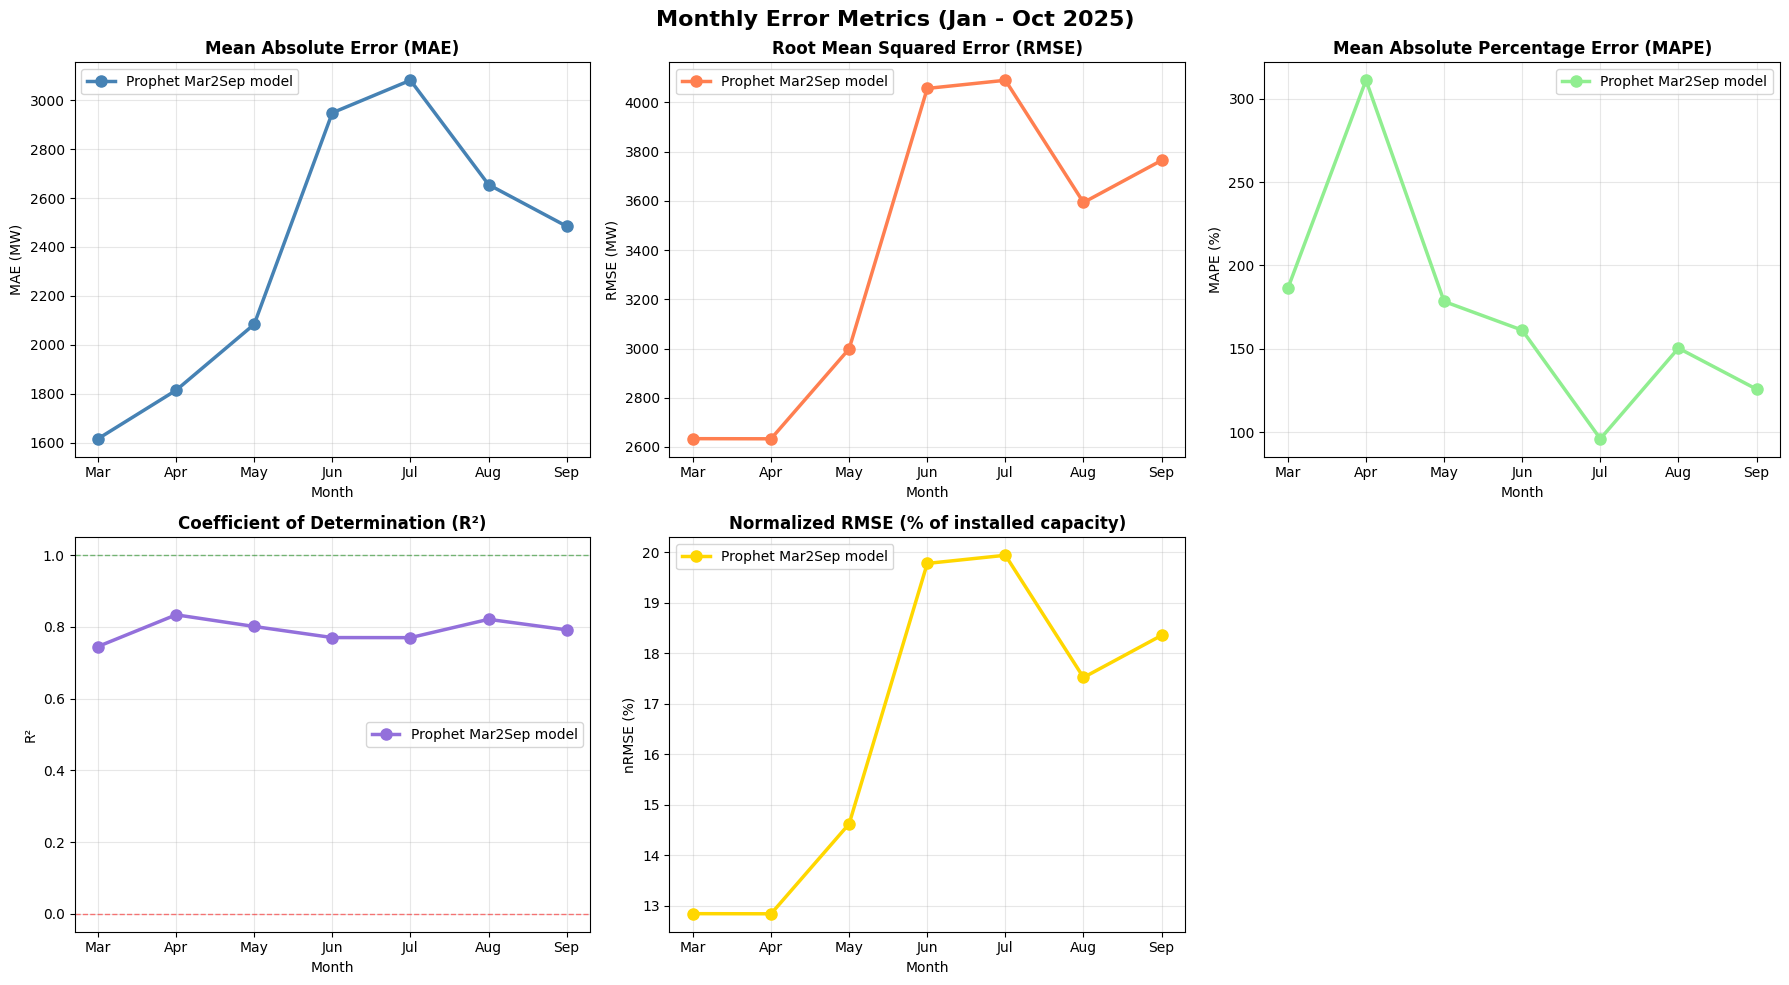


Monthly Error Metrics Summary Table:
Month         MAE        RMSE       MAPE       R²     nRMSE
  Mar 1615.166317 2633.784461 186.328670 0.745483 12.842780
  Apr 1813.716928 2633.249242 310.961197 0.833916 12.840170
  May 2083.606129 2998.741443 178.424034 0.801359 14.622372
  Jun 2948.994691 4057.073579 161.230214 0.770425 19.782979
  Jul 3082.156862 4090.257385  96.149552 0.770213 19.944789
  Aug 2655.082076 3593.526474 150.441980 0.821330 17.522645
  Sep 2484.729424 3764.713709 125.884772 0.791912 18.357383

Overall Statistics:
  Best R² Month: Apr (0.8339)
  Worst R² Month: Mar (0.7455)
  Lowest MAE Month: Mar (1615.17 MW)
  Highest MAE Month: Jul (3082.16 MW)


In [22]:
# Create monthly error metrics visualization
from sklearn.metrics import r2_score

# Get unique months from the comparison data
comparison['year_month'] = comparison['ds'].dt.to_period('M')
unique_months = sorted(comparison['year_month'].unique())

# Store metrics for each month
monthly_metrics_data = []

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        continue
    
    # Calculate metrics
    actual = month_data['y'].values
    predicted = month_data['yhat'].values
    
    # Calculate all metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # R²
    r2 = r2_score(actual, predicted)
    
    # nRMSE (normalized by installed capacity)
    nrmse = (rmse / installed_capacity) * 100
    
    monthly_metrics_data.append({
        'Month': month_period.strftime('%b'),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'nRMSE': nrmse
    })

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame(monthly_metrics_data)

# Create subplots for each metric (2x3 layout, reduced to 5 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Monthly Error Metrics (Jan - Oct 2025)', fontsize=16, fontweight='bold')

# Plot 1: MAE
ax1 = axes[0, 0]
ax1.plot(metrics_df['Month'], metrics_df['MAE'], marker='o', color='steelblue', 
         linewidth=2.5, markersize=8, label='Prophet Mar2Sep model')
ax1.set_title('Mean Absolute Error (MAE)', fontweight='bold')
ax1.set_ylabel('MAE (MW)')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: RMSE
ax2 = axes[0, 1]
ax2.plot(metrics_df['Month'], metrics_df['RMSE'], marker='o', color='coral', 
         linewidth=2.5, markersize=8, label='Prophet Mar2Sep model')
ax2.set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
ax2.set_ylabel('RMSE (MW)')
ax2.set_xlabel('Month')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Plot 3: MAPE
ax3 = axes[0, 2]
ax3.plot(metrics_df['Month'], metrics_df['MAPE'], marker='o', color='lightgreen', 
         linewidth=2.5, markersize=8, label='Prophet Mar2Sep model')
ax3.set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
ax3.set_ylabel('MAPE (%)')
ax3.set_xlabel('Month')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# Plot 4: R²
ax4 = axes[1, 0]
ax4.plot(metrics_df['Month'], metrics_df['R²'], marker='o', color='mediumpurple', 
         linewidth=2.5, markersize=8, label='Prophet Mar2Sep model')
ax4.set_title('Coefficient of Determination (R²)', fontweight='bold')
ax4.set_ylabel('R²')
ax4.set_xlabel('Month')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best')

# Plot 5: nRMSE
ax5 = axes[1, 1]
ax5.plot(metrics_df['Month'], metrics_df['nRMSE'], marker='o', color='gold', 
         linewidth=2.5, markersize=8, label='Prophet Mar2Sep model')
ax5.set_title('Normalized RMSE (% of installed capacity)', fontweight='bold')
ax5.set_ylabel('nRMSE (%)')
ax5.set_xlabel('Month')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best')

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print summary table
print("\nMonthly Error Metrics Summary Table:")
print("=" * 80)
print(metrics_df.to_string(index=False))
print("=" * 80)
print(f"\nOverall Statistics:")
print(f"  Best R² Month: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Month']} ({metrics_df['R²'].max():.4f})")
print(f"  Worst R² Month: {metrics_df.loc[metrics_df['R²'].idxmin(), 'Month']} ({metrics_df['R²'].min():.4f})")
print(f"  Lowest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Month']} ({metrics_df['MAE'].min():.2f} MW)")
print(f"  Highest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmax(), 'Month']} ({metrics_df['MAE'].max():.2f} MW)")


In [23]:
metrics_df.to_csv('pv_metrics_3-9.csv')
metrics_df

,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Mar,1615.166317,2633.784461,186.328670,0.745483,12.842780
1,Apr,1813.716928,2633.249242,310.961197,0.833916,12.840170
2,May,2083.606129,2998.741443,178.424034,0.801359,14.622372
3,Jun,2948.994691,4057.073579,161.230214,0.770425,19.782979
4,Jul,3082.156862,4090.257385,96.149552,0.770213,19.944789
5,Aug,2655.082076,3593.526474,150.441980,0.821330,17.522645
6,Sep,2484.729424,3764.713709,125.884772,0.791912,18.357383
